In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)
This code need to run in Spark enviorment.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [3]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

## Part1: Data ETL and Data Exploration

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [6]:
movies = spark.read.load("/FileStore/tables/movies.csv", format='csv', header = True)
ratings = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
links = spark.read.load("/FileStore/tables/links.csv", format='csv', header = True)
tags = spark.read.load("/FileStore/tables/tags.csv", format='csv', header = True)

In [7]:
movies.show(10)

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|Adventure|Animati...|
 2| Jumanji (1995)|Adventure|Childre...|
 3|Grumpier Old Men ...| Comedy|Romance|
 4|Waiting to Exhale...|Comedy|Drama|Romance|
 5|Father of the Bri...| Comedy|
 6| Heat (1995)|Action|Crime|Thri...|
 7| Sabrina (1995)| Comedy|Romance|
 8| Tom and Huck (1995)| Adventure|Children|
 9| Sudden Death (1995)| Action|
 10| GoldenEye (1995)|Action|Adventure|...|
+-------+--------------------+--------------------+
only showing top 10 rows

In [8]:
ratings.show(10)

+------+-------+------+---------+
userId|movieId|rating|timestamp|
+------+-------+------+---------+
 1| 1| 4.0|964982703|
 1| 3| 4.0|964981247|
 1| 6| 4.0|964982224|
 1| 47| 5.0|964983815|
 1| 50| 5.0|964982931|
 1| 70| 3.0|964982400|
 1| 101| 5.0|964980868|
 1| 110| 4.0|964982176|
 1| 151| 5.0|964984041|
 1| 157| 5.0|964984100|
+------+-------+------+---------+
only showing top 10 rows

In [9]:
tags.show()

+------+-------+-----------------+----------+
userId|movieId| tag| timestamp|
+------+-------+-----------------+----------+
 2| 60756| funny|1445714994|
 2| 60756| Highly quotable|1445714996|
 2| 60756| will ferrell|1445714992|
 2| 89774| Boxing story|1445715207|
 2| 89774| MMA|1445715200|
 2| 89774| Tom Hardy|1445715205|
 2| 106782| drugs|1445715054|
 2| 106782|Leonardo DiCaprio|1445715051|
 2| 106782| Martin Scorsese|1445715056|
 7| 48516| way too long|1169687325|
 18| 431| Al Pacino|1462138765|
 18| 431| gangster|1462138749|
 18| 431| mafia|1462138755|
 18| 1221| Al Pacino|1461699306|
 18| 1221| Mafia|1461699303|
 18| 5995| holocaust|1455735472|
 18| 5995| true story|1455735479|
 18| 44665| twist ending|1456948283|
 18| 52604| Anthony Hopkins|1457650696|
 18| 52604| courtroom drama|1457650711|
+------+-------+-----------------+----------+
only showing top 20 rows

In [10]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1

In [11]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user

## Part 1: Spark SQL and OLAP

In [13]:
#To figured out how many users in the dataset
num_users=ratings.select('userId').distinct().count()
print ('There are {} users in rating table'.format(num_users))

There are 610 users in rating table

In [14]:
#To find out how may movies in the dataset
num_movies=movies.select('movieId').distinct().count()
print ('There are {} movies in movies table'.format(num_movies))

There are 9742 movies in movies table

Cause number of movies is much more than the number of users, so maybe apply user-based model is more efficeint than item-based.

To find out how many movies are rated by users and any movies not rated before

In [17]:

ratings.createOrReplaceTempView("rat")
movies_rated=spark.sql("select count(movieId) from rat where rating==0 ")
#display(movies_rated)
movies_rated=sum(ratings.groupby('rating').count().toPandas()['count']==0)
print ('There are {} movies not rated before'.format(movies_rated))

There are 0 movies not rated before

To find out how many genres totally

In [19]:
genres_num=movies.select('genres').distinct().count()
genres=movies.select('genres')
#genres.show()
print('There are {} genres in movies table'.format(genres_num))

There are 951 genres in movies table

To find out how many movies in each genre

In [21]:
movies_num_genres=movies.groupBy('genres').count().orderBy('count', ascending=False)
movies_num_genres.show()

+--------------------+-----+
 genres|count|
+--------------------+-----+
 Drama| 1053|
 Comedy| 946|
 Comedy|Drama| 435|
 Comedy|Romance| 363|
 Drama|Romance| 349|
 Documentary| 339|
Comedy|Drama|Romance| 276|
 Drama|Thriller| 168|
 Horror| 167|
 Horror|Thriller| 135|
 Crime|Drama| 134|
Crime|Drama|Thriller| 125|
 Drama|War| 114|
 Comedy|Crime| 101|
 Action|Comedy| 92|
 Thriller| 84|
 Children|Comedy| 74|
 Comedy|Horror| 69|
Action|Adventure|...| 66|
Action|Crime|Thri...| 66|
+--------------------+-----+
only showing top 20 rows

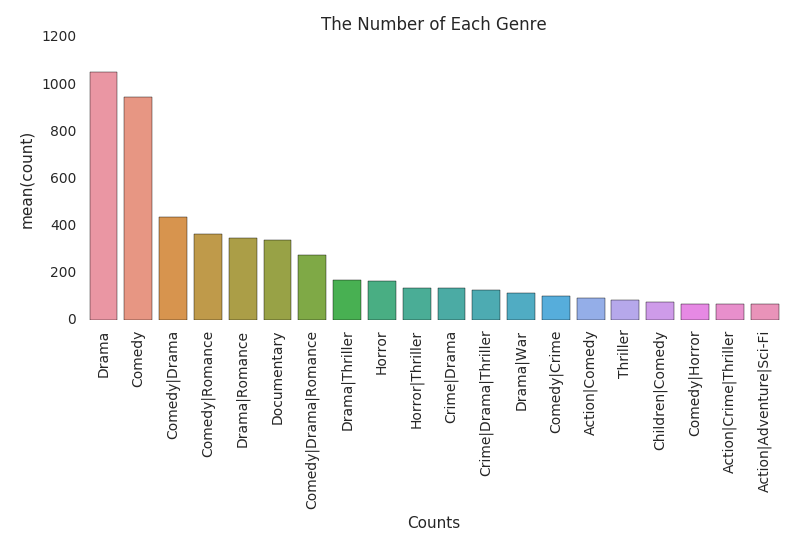

In [22]:
fig, axes = plt.subplots(1,1)
genres_count = movies_num_genres.toPandas()
genres_count=genres_count[:20]
sns.barplot(y="count", x="genres",data=genres_count,ax=axes)
plt.xlabel("Counts")
plt.title("The Number of Each Genre")
plt.xticks(rotation=90)
plt.tight_layout()
display(fig.show())

## Part2: Spark ALS based approach for training model
We will use an RDD-based API from [pyspark.mllib](https://spark.apache.org/docs/2.1.1/mllib-collaborative-filtering.html) to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

### Please refer to Spark ML ALS model
https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/4999972933037924/899848065201823/8135547933712821/latest.html

In [24]:
#from pyspark.ml.recommendation import ALS
from pyspark.mllib.recommendation import ALS
from pyspark.sql import Row

In [25]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

ratings = ratings.select("userId", "movieId", "rating")
# inspect the schema 
ratings.printSchema()

root
-- userId: string (nullable = true)
-- movieId: string (nullable = true)
-- rating: string (nullable = true)

In [26]:
data_rating = ratings.withColumn('userId', ratings['userId'].cast('int')).\
withColumn('movieId', ratings['movieId'].cast('int')).withColumn('rating', ratings['rating'].cast('float'))
# inspect the schema 
data_rating.printSchema()

root
-- userId: integer (nullable = true)
-- movieId: integer (nullable = true)
-- rating: float (nullable = true)

Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [28]:
train, validation, test = data_rating.randomSplit([0.6,0.2,0.2],seed = 1)
print ("The number of ratings in each set: {}, {}, {}".format(train.count(), validation.count(), test.count()))

The number of ratings in each set: 60567, 20061, 20208

In [29]:
train.cache()

Out[ 29 ]: DataFrame[userId: int, movieId: int, rating: float]

In [30]:
validation.cache()

Out[ 30 ]: DataFrame[userId: int, movieId: int, rating: float]

In [31]:
test.cache()

Out[ 31 ]: DataFrame[userId: int, movieId: int, rating: float]

Applied mean value of each movie as the prediction, and then we could compare the model performance between the mean-value model and the collaborative-fitering model accoring to Root Mean Square Erroe(rmse).

In [33]:
mean_rating=train.groupby('movieId').mean().select('movieId','avg(rating)')
mean_rating = mean_rating.withColumnRenamed('avg(rating)','prediction')
mean_rating.count()
#display(mean_rating)
mean_rating.show(10)

+-------+------------------+
movieId| prediction|
+-------+------------------+
 2366| 3.764705882352941|
 1088| 3.46|
 1580| 3.442857142857143|
 32460| 4.0|
 44022|3.4583333333333335|
 96488| 4.333333333333333|
 1238| 3.9375|
 1591|2.6176470588235294|
 1645|3.4393939393939394|
 3175|3.5106382978723403|
+-------+------------------+
only showing top 10 rows

We could join the train table with test table on same movieId, and then caculate RMSE of the test data set

In [35]:
test.createOrReplaceTempView("test")
mean_rating.createOrReplaceTempView("mean_rating")

sqlDF = spark.sql("select test.*, mean_rating.prediction \
                   from test join mean_rating \
                   on test.movieId = mean_rating.movieId")
#display(sqlDF)
sqlDF.count()
sqlDF.show(5)

+------+-------+------+-----------------+
userId|movieId|rating| prediction|
+------+-------+------+-----------------+
 493| 2366| 2.0|3.764705882352941|
 448| 2366| 5.0|3.764705882352941|
 39| 2366| 5.0|3.764705882352941|
 600| 1088| 3.5| 3.46|
 583| 1088| 3.5| 3.46|
+------+-------+------+-----------------+
only showing top 5 rows

In [36]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
def RMSE(predictions):
    return evaluator.evaluate(predictions)

In [37]:
print ('Using the mean rating of each movie as the prediction, the testing RMSE is ' + str(RMSE(sqlDF)))

Using the mean rating of each movie as the prediction, the testing RMSE is 0.9684681096936459

### ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [39]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_rmse = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # make prediction
            # get the rating result
            # get the RMSE
            als = ALS(rank = rank, 
                      maxIter = num_iterations, 
                      seed = 1, 
                      regParam = reg,
                      userCol="userId", 
                      itemCol="movieId", 
                      ratingCol="rating", 
                      coldStartStrategy="drop") 
            #error = None
            model = als.fit(train)
            predictions = model.transform(validation_data)
            #evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
            rmse = RMSE(predictions)
            
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_rmse:
                min_rmse = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    pred = best_model.transform(train)
    train_rmse = RMSE(pred)
    print ('traning RMSE is {}; validation RMSE is {}'.format(train_rmse, min_rmse))
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [40]:
num_iterations = 10
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

import time
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.05: validation RMSE is 0.9766416162998439
6 latent factors and regularization = 0.1: validation RMSE is 0.9124975447342438
6 latent factors and regularization = 0.2: validation RMSE is 0.8937841733801742
6 latent factors and regularization = 0.4: validation RMSE is 0.9626450319320567
6 latent factors and regularization = 0.8: validation RMSE is 1.1811223220496179
8 latent factors and regularization = 0.05: validation RMSE is 0.9939192808387594
8 latent factors and regularization = 0.1: validation RMSE is 0.916835902626747
8 latent factors and regularization = 0.2: validation RMSE is 0.8946289005096189
8 latent factors and regularization = 0.4: validation RMSE is 0.9624533854803139
8 latent factors and regularization = 0.8: validation RMSE is 1.181089011676798
10 latent factors and regularization = 0.05: validation RMSE is 1.0000582726052745
10 latent factors and regularization = 0.1: validation RMSE is 0.919667470168828
10 latent factors and regularization = 0.2: validation RMSE is 0.8963509045007014
10 latent factors and regularization = 0.4: validation RMSE is 0.9625753196982239
10 latent factors and regularization = 0.8: validation RMSE is 1.1811131335784153
12 latent factors and regularization = 0.05: validation RMSE is 1.0087194992127675
12 latent factors and regularization = 0.1: validation RMSE is 0.9162178021866768
12 latent factors and regularization = 0.2: validation RMSE is 0.894727484888669
12 latent factors and regularization = 0.4: validation RMSE is 0.9628509915478566
12 latent factors and regularization = 0.8: validation RMSE is 1.1810974954336622
14 latent factors and regularization = 0.05: validation RMSE is 1.0147499730431686
14 latent factors and regularization = 0.1: validation RMSE is 0.9187622802761995
14 latent factors and regularization = 0.2: validation RMSE is 0.8952361734207187
14 latent factors and regularization = 0.4: validation RMSE is 0.9628224519860767
14 latent factors and regularization = 0.8: validation RMSE is 1.1811107621037311
traning RMSE is 0.6894984317476609; validation RMSE is 0.8937841733801742

The best model has 6 latent factors and regularization = 0.2
Total Runtime: 670.27 seconds

Select 3 numbers according to last model traing result and then Gradient Search again to find out the best hyper-parameter

In [42]:
num_iterations = 20
ranks = [5, 6, 7]
reg_params = [0.1, 0.2, 0.3]

final_model=train_ALS(train, validation, num_iterations, reg_params, ranks)

5 latent factors and regularization = 0.1: validation RMSE is 0.912991014669153
5 latent factors and regularization = 0.2: validation RMSE is 0.8959979908871762
5 latent factors and regularization = 0.3: validation RMSE is 0.9214842302271261
6 latent factors and regularization = 0.1: validation RMSE is 0.911184988997912
6 latent factors and regularization = 0.2: validation RMSE is 0.8944181771079912
6 latent factors and regularization = 0.3: validation RMSE is 0.9211817900185335
7 latent factors and regularization = 0.1: validation RMSE is 0.9112996472460129
7 latent factors and regularization = 0.2: validation RMSE is 0.8951044358540294
7 latent factors and regularization = 0.3: validation RMSE is 0.9214938981221121
traning RMSE is 0.6853796706283821; validation RMSE is 0.8944181771079912

The best model has 6 latent factors and regularization = 0.2

### Model testing on the test data
And finally, wite your code to make a prediction and check the testing error.

In [44]:
pred_test = final_model.transform(test)
print ('The testing RMSE is ' + str(RMSE(pred_test)))

The testing RMSE is 0.8884978333224407

According to the RMSE result comparsion between Mean-Value model (0.9684681096936459) and Collaborative-Fitering model (0.8884978333224407), we could see that although the result may not cause hug improvement, the data is limited, and I believe in real-world with huge amount data, the Collaborative-Fitering model could performe much better.